<a href="https://colab.research.google.com/github/mylonasc/compeng/blob/master/10_11_2021_Opensees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python3 -m pip install openseespy

In [2]:
!wget https://openseespydoc.readthedocs.io/en/latest/_downloads/0cfff7e8223b857f6259a885d69a2d62/RCFrameGravity.py
!wget https://openseespydoc.readthedocs.io/en/latest/_downloads/b1b63c7deee01adbfaf9497b9dd579bd/ReadRecord.py
!wget https://openseespydoc.readthedocs.io/en/latest/_downloads/51bc5b08c616a2a0c5a0eadb66c51054/elCentro.at2

--2021-11-10 10:56:16--  https://openseespydoc.readthedocs.io/en/latest/_downloads/0cfff7e8223b857f6259a885d69a2d62/RCFrameGravity.py
Resolving openseespydoc.readthedocs.io (openseespydoc.readthedocs.io)... 104.17.33.82, 104.17.32.82, 2606:4700::6811:2152, ...
Connecting to openseespydoc.readthedocs.io (openseespydoc.readthedocs.io)|104.17.33.82|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4644 (4.5K) [text/x-python]
Saving to: ‘RCFrameGravity.py.1’

RCFrameGravity.py.1 100%[===================>]   4.54K  --.-KB/s    in 0s      

2021-11-10 10:56:16 (55.4 MB/s) - ‘RCFrameGravity.py.1’ saved [4644/4644]

--2021-11-10 10:56:16--  https://openseespydoc.readthedocs.io/en/latest/_downloads/b1b63c7deee01adbfaf9497b9dd579bd/ReadRecord.py
Resolving openseespydoc.readthedocs.io (openseespydoc.readthedocs.io)... 104.17.33.82, 104.17.32.82, 2606:4700::6811:2052, ...
Connecting to openseespydoc.readthedocs.io (openseespydoc.readthedocs.io)|104.17.33.82|:443... connecte


## Running el-Centro earthquake to a concrete frame
based on the code [here](https://openseespydoc.readthedocs.io/en/latest/src/RCFrameEarthquake.html)


Start RCFrameEarthquake Example
Starting RCFrameGravity example
Passed!
Gravity Analysis Completed
eigen values at start of transient: [266.85892092337207, 17504.422568344115]
eigen values at end of transient: [159.95037953233754, 17300.469482471242]
Passed!


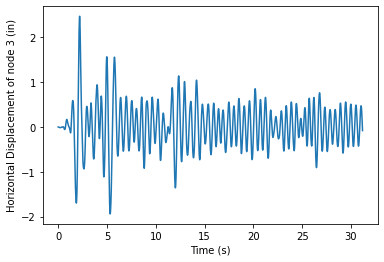

In [3]:
print("==========================")
print("Start RCFrameEarthquake Example")

# Units: kips, in, sec  
#
# Written: Minjie

from openseespy.opensees import *

import ReadRecord
import numpy as np
import matplotlib.pyplot as plt

wipe()
# ----------------------------------------------------
# Start of Model Generation & Initial Gravity Analysis
# ----------------------------------------------------

# Do operations of Example3.1 by sourcing in the tcl file
import RCFrameGravity
print("Gravity Analysis Completed")

# Set the gravity loads to be constant & reset the time in the domain
loadConst('-time', 0.0)

# ----------------------------------------------------
# End of Model Generation & Initial Gravity Analysis
# ----------------------------------------------------

# Define nodal mass in terms of axial load on columns
g = 386.4
m = RCFrameGravity.P/g

mass(3, m, m, 0.0)
mass(4, m, m, 0.0)

# Set some parameters
record = 'elCentro'

# Permform the conversion from SMD record to OpenSees record
dt, nPts = ReadRecord.ReadRecord(record+'.at2', record+'.dat')

# Set time series to be passed to uniform excitation
timeSeries('Path', 2, '-filePath', record+'.dat', '-dt', dt, '-factor', g)

# Create UniformExcitation load pattern
#                         tag dir 
pattern('UniformExcitation',  2,   1,  '-accel', 2)

# set the rayleigh damping factors for nodes & elements
rayleigh(0.0, 0.0, 0.0, 0.000625)

# Delete the old analysis and all it's component objects
wipeAnalysis()

# Create the system of equation, a banded general storage scheme
system('BandGeneral')

# Create the constraint handler, a plain handler as homogeneous boundary
constraints('Plain')

# Create the convergence test, the norm of the residual with a tolerance of 
# 1e-12 and a max number of iterations of 10
test('NormDispIncr', 1.0e-12,  10 )

# Create the solution algorithm, a Newton-Raphson algorithm
algorithm('Newton')

# Create the DOF numberer, the reverse Cuthill-McKee algorithm
numberer('RCM')

# Create the integration scheme, the Newmark with alpha =0.5 and beta =.25
integrator('Newmark',  0.5,  0.25 )

# Create the analysis object
analysis('Transient')

# Perform an eigenvalue analysis
numEigen = 2
eigenValues = eigen(numEigen)
print("eigen values at start of transient:",eigenValues)

# set some variables
tFinal = nPts*dt
tCurrent = getTime()
ok = 0

time = [tCurrent]
u3 = [0.0]

# Perform the transient analysis
while ok == 0 and tCurrent < tFinal:
    
    ok = analyze(1, .01)
    
    # if the analysis fails try initial tangent iteration
    if ok != 0:
        print("regular newton failed .. lets try an initail stiffness for this step")
        test('NormDispIncr', 1.0e-12,  100, 0)
        algorithm('ModifiedNewton', '-initial')
        ok =analyze( 1, .01)
        if ok == 0:
            print("that worked .. back to regular newton")
        test('NormDispIncr', 1.0e-12,  10 )
        algorithm('Newton')
    
    tCurrent = getTime()

    time.append(tCurrent)
    u3.append(nodeDisp(3,1))



# Perform an eigenvalue analysis
eigenValues = eigen(numEigen)
print("eigen values at end of transient:",eigenValues)

results = open('results.out','a+')

if ok == 0:
    results.write('PASSED : RCFrameEarthquake.py\n');
    print("Passed!")
else:
    results.write('FAILED : RCFrameEarthquake.py\n');
    print("Failed!")

results.close()

plt.plot(time, u3)
plt.ylabel('Horizontal Displacement of node 3 (in)')
plt.xlabel('Time (s)')

plt.show()